In [39]:
import deepxde as dde

import numpy as np
import torch

import baseclass
'''
Based on these reference codes
[1] Lid-driven cavity problem: https://github.com/i207M/PINNacle/blob/595ab6898a30d27ac6cd44ff0a465482f8c52f5c/src/pde/ns.py
[2] Visualization: https://github.com/lululxvi/deepxde/issues/634
'''
dde.config.set_random_seed(42)

# PDE
def liddriven_pde(x, u):
    nu = 0.01
    u_vel, v_vel, _ = u[:, [0]], u[:, [1]], u[:, [2]]
    u_vel_x = dde.grad.jacobian(u, x, i=0, j=0)
    u_vel_y = dde.grad.jacobian(u, x, i=0, j=1)
    u_vel_xx = dde.grad.hessian(u, x, component=0, i=0, j=0)
    u_vel_yy = dde.grad.hessian(u, x, component=0, i=1, j=1)

    v_vel_x = dde.grad.jacobian(u, x, i=1, j=0)
    v_vel_y = dde.grad.jacobian(u, x, i=1, j=1)
    v_vel_xx = dde.grad.hessian(u, x, component=1, i=0, j=0)
    v_vel_yy = dde.grad.hessian(u, x, component=1, i=1, j=1)

    p_x = dde.grad.jacobian(u, x, i=2, j=0)
    p_y = dde.grad.jacobian(u, x, i=2, j=1)

    momentum_x = (u_vel * u_vel_x + v_vel * u_vel_y + p_x - nu * (u_vel_xx + u_vel_yy))
    momentum_y = (u_vel * v_vel_x + v_vel * v_vel_y + p_y - nu * (v_vel_xx + v_vel_yy))
    continuity = u_vel_x + v_vel_y

    return [momentum_x, momentum_y, continuity]

# Geometry
bbox=[0, 1, 0, 1]
geom = dde.geometry.Rectangle(xmin=[bbox[0], bbox[2]], xmax=[bbox[1], bbox[3]])

# BC
def boundary_top(x, on_boundary):
    return on_boundary and np.isclose(x[1], bbox[3])

def boundary_not_top(x, on_boundary):
    return on_boundary and not np.isclose(x[1], bbox[3])
# def funU(x):
#     return 1.0
# def funV(x):
#     return 0.0
# bc_u = dde.DirichletBC(geom, funU, boundary_not_top, component=0)
# bc_v = dde.DirichletBC(geom, funV, boundary_not_top, component=1)
bc_u = dde.DirichletBC(geom, (lambda _: 1), boundary_not_top, component=0)
bc_v = dde.DirichletBC(geom, (lambda _: 0), boundary_not_top, component=1)
bcs = [bc_u, bc_v]

# Data
data = dde.data.PDE(geom, liddriven_pde, bcs, num_domain=2000, num_boundary=400, num_test=5000)

# Model
layer_size = [2] + [20]*5 + [3]
activation = 'tanh'
initializer = 'Glorot uniform'
net = dde.nn.FNN(layer_size, activation, initializer)

# Hard-constraints
def output_transform(x, u):
    '''
    Hard-constraints are imposed only on the top plane
    : when y=1 -> u=1 & v=0
    '''
    u_x = u[:, [0]] * (x[:, [1]] - 1) + 1
    u_v = u[:, [1]] * (x[:, [1]] - 1)
    return torch.concat((u_x, u_v, u[:,[2]]), axis=1)

net.apply_output_transform(output_transform)

# Compile & Train - ADAM
'''
For more options: https://deepxde.readthedocs.io/en/latest/modules/deepxde.html#module-deepxde.model
'''
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations = 10000, display_every = 100, model_save_path = './')
# dde.saveplot(losshistory, train_state, issave = True, isplot = True)

# Compile & Train - L-BFGS-B
model.compile(optimizer = 'L-BFGS-B')
losshistory, train_state = model.train(display_every = 100, model_save_path = './')

Compiling model...
'compile' took 0.000075 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [6.58e-02, 3.55e-01, 2.78e-01, 6.14e-02, 5.23e-02]    [6.41e-02, 3.52e-01, 2.92e-01, 6.14e-02, 5.23e-02]    []  
100       [2.96e-05, 5.55e-05, 2.08e-04, 5.34e-05, 1.58e-05]    [2.20e-05, 4.78e-05, 1.73e-04, 5.34e-05, 1.58e-05]    []  
200       [1.51e-05, 3.16e-05, 8.53e-05, 1.03e-05, 1.06e-05]    [1.16e-05, 2.66e-05, 7.11e-05, 1.03e-05, 1.06e-05]    []  
300       [1.33e-05, 2.18e-05, 4.02e-05, 7.58e-06, 6.34e-06]    [1.11e-05, 1.81e-05, 3.38e-05, 7.58e-06, 6.34e-06]    []  
400       [1.26e-05, 1.72e-05, 2.35e-05, 6.14e-06, 4.32e-06]    [1.08e-05, 1.42e-05, 1.97e-05, 6.14e-06, 4.32e-06]    []  
500       [1.13e-05, 1.36e-05, 1.64e-05, 5.20e-06, 3.28e-06]    [9.76e-06, 1.12e-05, 1.37e-05, 5.20e-06, 3.28e-06]    []  
600       [9.87e-06, 1.06e-05, 1.26e-05, 4.49e-06, 2.66e-06]    [8.

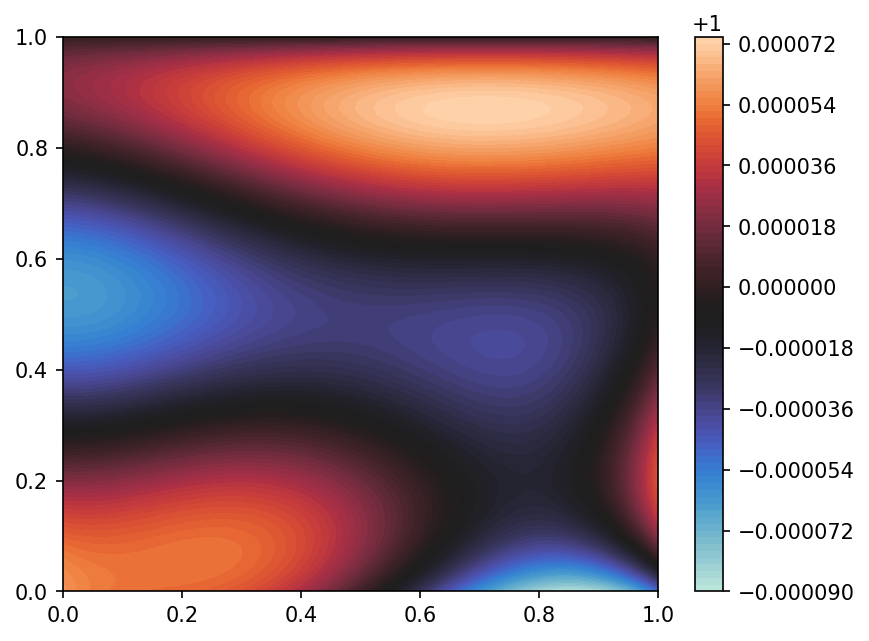

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
x1_test = np.linspace(bbox[0], bbox[1], 101)
x2_test = np.linspace(bbox[2], bbox[3], 102)
X_test = np.zeros((len(x1_test)*len(x2_test), 2))
X_test[:, 0] = np.vstack((x1_test,)*len(x2_test)).reshape(-1)
X_test[:, 1] = np.vstack((x2_test,)*len(x1_test)).T.reshape(-1)
# x1_indices = np.argsort(X_test, axis=0)[:,0]
# X_test = X_test[x1_indices]
# print(X_test[:,0])
Y_test = model.predict(X_test)

def plot_flowfield(x, y, u, v):
    u = u.reshape(len(x2_test), len(x1_test))
    v = v.reshape(len(x2_test), len(x1_test))
    fig, ax = plt.subplots(dpi=150)
    # ax.streamplot(x1_test, x2_test, u, v, density=1.5)
    img = ax.contourf(x1_test, x2_test, u, levels=101, cmap=sns.color_palette("icefire", as_cmap=True))
    # plt.plot(boundaryNACA4D(0, 0, 12, 1, 100)[:, 0], boundaryNACA4D(0, 0, 12, 1, 100)[:, 1])
    fig.colorbar(img)
    fig.savefig('NACA0012NS.png')

plot_flowfield(x=X_test[:, 0], y=X_test[:, 1], u=Y_test[:,0], v=Y_test[:,1])

In [26]:
print(Y_test[:,1].shape)

(10201,)
